In [2]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2lab, lab2rgb
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import color # For rgb2la & lab2rgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [3]:
# !pip install fastai==2.4

In [4]:
DATA_DIR = './data'
BATCH_SIZE = 16
IMG_SIZE = 256
NUM_WORKERS = 4

Although we are using the same dataset and number of training samples, the exact 8000 images that you train your model on may vary (although we are seeding!) because the dataset here has only 20000 images with different ordering while I sampled 10000 images from the complete dataset.

### 1.2- Making Datasets and DataLoaders

I hope the code is self-explanatory. I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then I'm making the data loaders.

In [5]:
class_names = ['lionfish', 'pufferfish', 'sea_anemone', 'sea_cucumber', 'sea_snake']
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE),  Image.BICUBIC),
                # (Train-only) data augmentation
                # TODO: Try different variants?
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((IMG_SIZE, IMG_SIZE),  Image.BICUBIC)

        self.split = split
        self.paths = paths
    
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img_rgb = Image.open(img_path).convert("RGB")
        img_rgb = self.transforms(img_rgb)
        img_rgb = np.array(img_rgb)
        img_lab = color.rgb2lab(img_rgb).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        # TODO: Understand this (why not use a Torch transform?)
        L  = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        # Store L and ab channels, as well as class
        return { 'L': L, 'ab': ab, 'class': self.map_class(img_path.split('/')[-2]) }
    
    def __len__(self):
        return len(self.paths)
        
    def map_class(self, cls):
        for i, name in enumerate(class_names):
            if cls==name: 
                return i
        print(f"Invalid class name '{cls}'!")
        """
        if cls=='sea_anemone':
            return 0
        if cls=='pufferfish':
            return 1
        if cls=='sea_cucumber':
            return 2
        if cls=='sea_snake':
            return 3
        if cls=='lionfish':
            return 4
        """

In [6]:
train_paths = []
val_paths = []

for subdir, dirs, files in os.walk(DATA_DIR + "/train"):
    if len(files) == 0: continue
    for file in files:
        if file.endswith('.JPEG'):
            train_paths.append(subdir + "/" + file)

for subdir, dirs, files in os.walk(DATA_DIR + "/val"):
    if len(files) == 0: continue
    for file in files:
        if file.endswith('.JPEG'):
            val_paths.append(subdir + "/" + file)

train_dataset = ColorizationDataset(train_paths, split='train')
val_dataset   = ColorizationDataset(val_paths,   split='val')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=True)

print("Train:", len(train_dataset), "samples ·", len(train_dataloader), "batches")
print("Val:", len(val_dataset), "samples ·", len(val_dataloader), "batches")

Train: 6500 samples · 407 batches
Val: 250 samples · 16 batches


/home/damastah/miniconda3/envs/dml-gpu/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [7]:
# Sanity check: looks good!
for batch in train_dataloader:
    print(batch['L'].shape, batch['ab'].shape, batch['class'])
    break

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256]) tensor([4, 0, 4, 0, 2, 0, 4, 1, 0, 2, 1, 0, 3, 0, 2, 0])


### 1.4- Discriminator

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [8]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [9]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [10]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

### 1.5- GAN Loss

This is a handy class we can use to calculate the GAN loss of our final model. In the __init__ we decide which kind of loss we're going to use (which will be "vanilla" in our project) and register some constant tensors as the "real" and "fake" labels. Then when we call this module, it makes an appropriate tensor full of zeros or ones (according to what we need at the stage) and computes the loss.

In [11]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

In the TowardsDataScince article, I didn't explain this function. Here is our logic to initialize our models. We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article:

In [12]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class brings together all the previous parts and implements a few methods to take care of training our complete model. Let's investigate it.

In the __init__ we define our generator and discriminator using the previous functions and classes we defined and we also initialize them with init_model function which I didn't explain here but you can refer to my GitHub repository to see how it works. Then we define our two loss functions and the optimizers of the generator and discriminator.

The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class.

Then, we first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss.
Now, we can train the generator. In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. As I mentioned earlier, we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [13]:
class ClassifierHead(nn.Module):
  def __init__(self, input_size=512*8*8, output_size=5):
        super().__init__()

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, output_size)

  def forward(self, x):
      x = self.fc1(x)
      return self.fc2(self.relu(x))

class ColorizationHead(nn.Module):
  def __init__(self, input_c=1, output_c=2, n_down=5, num_filters=512):
        super().__init__()
        self.model_layers = []
        self.model_layers += (self.get_layer(num_filters, num_filters))
        for _ in range(n_down - 5):
            self.model_layers += (self.get_layer(num_filters, num_filters, dropout=True))
        out_filters = num_filters
        for _ in range(3):
            self.model_layers += (self.get_layer(out_filters // 2, out_filters))
            out_filters //= 2
        self.model_layers += (self.get_layer(output_c, out_filters, outermost=True))
        self.model = nn.Sequential(*self.model_layers)

  def forward(self, x):
      return self.model(x)

  def get_layer(self, nf, ni, bias=False, dropout=False, outermost=False):
        layer = []
        conv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                              stride=2, padding=1, bias=bias)
        relu = nn.ReLU(False)

        layer.append(relu)
        layer.append(conv)

        if outermost:
          layer.append(nn.Tanh())
        else:
          layer.append(nn.BatchNorm2d(nf))

        if dropout:
          layer.append(nn.Dropout(0.5))

        return layer

class MLTModel(nn.Module):
  def __init__(self, head="multitask"):
          super().__init__()
          self.resnet_body = create_body(resnet18, pretrained=True, n_in=1, cut=-2)

          # Freeze backbone -- only perform transfer learning (easy to motivate in the report)
          for param in self.resnet_body.parameters():
              param.requires_grad = False

          self.heads = []
          self.head = head
          if head=="multitask":
            self.classifier_head = ClassifierHead()
            self.colorization_head = ColorizationHead()
          elif head=="classifier":
            self.classifier_head = ClassifierHead()
          elif self.head=="colorization":
            self.colorization_head = ColorizationHead()
          else:
              raise Exception('Invalid head')
  def forward(self, x):
      if self.head=="multitask":
          x = self.resnet_body(x)
          out_classifier = self.classifier_head(x.view(-1, 512*8*8))
          out_colorization_head = self.colorization_head(x)
          return out_classifier, out_colorization_head
      elif self.head=="classifier":
          x = self.resnet_body(x)
          out_classifier = self.classifier_head(x.view(-1, 512*8*8))
          return out_classifier
      elif self.head=="colorization":
          x = self.resnet_body(x)
          out_colorization_head = self.colorization_head(x)
          return out_colorization_head

In [32]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100., lambda_CE=10.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.lambda_CE = lambda_CE

        if net_G is None:
            self.net_G = init_model(MLTModel(), self.device)
            print(self.net_G.parameters())
        else:
            self.net_G = net_G.to(self.device)
        self.head = self.net_G.head
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.class_criterion = nn.CrossEntropyLoss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        self.labels = data['class'].to(self.device)
            
            
    def forward(self):
        g_out = self.net_G(self.L)
        if self.head=="multitask":
            self.fake_color = g_out[1]
            self.class_pred = g_out[0]
        elif self.head=="classifier":
            self.class_pred = g_out
        elif self.head=="colorization":
            self.fake_color = g_out
        # print(f"Class preds: {torch.argmax(self.class_pred, dim=1)}")

    def backward_D(self):
        # print(f"L shape: {self.L.shape}")
        # print(f"self.fake_color shape: {self.fake_color.shape}")
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def validate(self):
        with torch.no_grad():
            losses_list = []
            if self.head in ["multitask",  "colorization"]:
                fake_image = torch.cat([self.L, self.fake_color], dim=1)
                fake_preds = self.net_D(fake_image.detach())
                self.loss_G_GAN = self.GANcriterion(fake_preds, True)
                self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
                losses_list.append(self.loss_G_GAN)
                losses_list.append(self.loss_G_L1)

            if self.head in ["multitask",  "classifier"]:
                self.class_loss = self.class_criterion(self.class_pred, self.labels) * (self.lambda_CE if 'multitask' else 1.0)
                losses_list.append(self.class_loss)
                max_pred = self.class_pred.argmax(dim=1)
                self.class_accuracy = (max_pred == self.labels).sum()
                # print(max_pred)
                # print(self.labels)
            
            # self.loss_G = self.loss_G_GAN + self.loss_G_L1 + self.class_loss
            self.loss_G = sum(losses_list)

    def backward_G(self):
        losses_list = []

        # Colorization loss
        if self.head in ["multitask",  "colorization"]:
            fake_image = torch.cat([self.L, self.fake_color], dim=1)
            fake_preds = self.net_D(fake_image)
            self.loss_G_GAN = self.GANcriterion(fake_preds, True)
            self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
            losses_list.append(self.loss_G_GAN)
            losses_list.append(self.loss_G_L1)

        # Classification loss
        if self.head in ["multitask",  "classifier"]:
            self.class_loss = self.class_criterion(self.class_pred, self.labels) * (self.lambda_CE if 'multitask' else 1.0)
            losses_list.append(self.class_loss)
            max_pred = self.class_pred.argmax(dim=1)
            self.class_accuracy = (max_pred == self.labels).sum()
            # print(max_pred)
            # print(self.labels)
        
        # NOTE: Are we sure this summation works with autograd?
        # self.loss_G = self.loss_G_GAN + self.loss_G_L1 + self.class_loss
        self.loss_G = sum(losses_list)
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        if self.head!="classifier":
            self.net_D.train()
            self.set_requires_grad(self.net_D, True)
            self.opt_D.zero_grad()
            self.backward_D()
            self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

These functions were nor included in the explanations of the TDS article. These are just some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [33]:
class AverageMeter:
    def __init__(self):
        self.reset()
        self.history_losses = []

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1, acc=False):
        if acc:
            self.count += count
            self.sum += val
            self.avg = self.sum / self.count
        else:
            self.count += count
            self.sum += count * val
            self.avg = self.sum / self.count

        # Average within the batch
        self.history_losses.append(val / count)

def clear_losses(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss_meter.reset()
        
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    class_loss = AverageMeter()
    class_accuracy = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G,
            'class_loss': class_loss,
            'class_accuracy': class_accuracy}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        try:
            if loss_name == 'class_accuracy':
                acc = True
            else:
                acc=False
            loss = getattr(model, loss_name)
            loss_meter.update(loss.item(), count=count, acc=acc)
        except AttributeError:
            pass

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    # NOTE: I think something about this leads to clipping, right (according to the UserWarnings)?
    # https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.lab2rgb
    # Oh, that's probably because the model's output isn't clipped. A simple test below suggests
    # that it indeed is working.
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        #print(type(img), img.shape, img)
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        if loss_name == 'class_accuracy':
            print(f"{loss_name}: {loss_meter.avg:.5f}%")
        else:
            print(f"{loss_name}: {loss_meter.avg:.5f}")

In [34]:
#data = next(iter(val_dataloader))
#img_rgb = lab_to_rgb(data['L'], data['ab'])
#plt.imshow(img_rgb[4])

I hope this code is self-explanatory. Every epoch takes about 4 minutes on not a powerful GPU as Nvidia P5000. So if you are using 1080Ti or higher, it will be much faster.

model initialized with norm initialization


  0%|          | 0/407 [00:00<?, ?it/s]


Epoch 1/2
Iteration 300/407
Test losses:
loss_D_fake: 0.25724
loss_D_real: 0.26336
loss_D: 0.26030
loss_G_GAN: 2.56431
loss_G_L1: 13.98056
loss_G: 23.32206
class_loss: 6.77719
class_accuracy: 0.80312%
Validation losses:
loss_D_fake: 0.00000
loss_D_real: 0.00000
loss_D: 0.00000
loss_G_GAN: 0.00000
loss_G_L1: 0.00000
loss_G: 0.00000
class_loss: 0.00000
class_accuracy: 0.00000%


/tmp/ipykernel_21849/4161406293.py:72: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 782 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


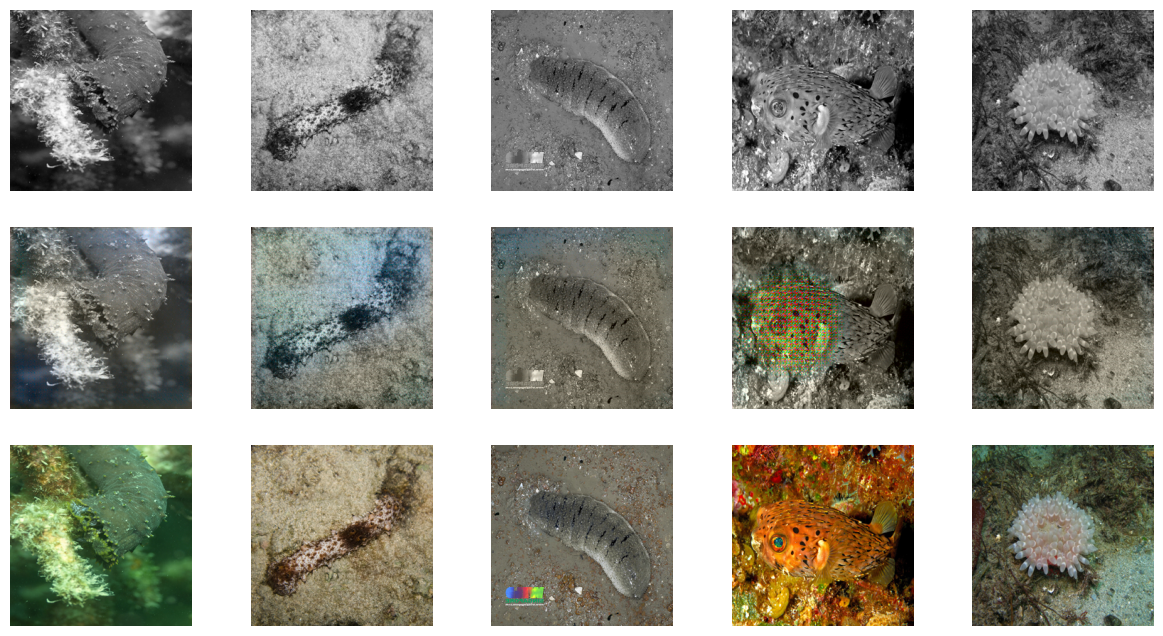

  0%|          | 0/407 [00:00<?, ?it/s]


Epoch 2/2
Iteration 300/407
Test losses:
loss_D_fake: 0.04985
loss_D_real: 0.05066
loss_D: 0.05026
loss_G_GAN: 4.81043
loss_G_L1: 12.95688
loss_G: 21.03214
class_loss: 3.26484
class_accuracy: 0.88729%
Validation losses:
loss_D_fake: 0.00000
loss_D_real: 0.00000
loss_D: 0.00000
loss_G_GAN: 0.00000
loss_G_L1: 0.00000
loss_G: 0.00000
class_loss: 0.00000
class_accuracy: 0.00000%


/tmp/ipykernel_21849/4161406293.py:72: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8940 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
/tmp/ipykernel_21849/4161406293.py:72: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 210 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


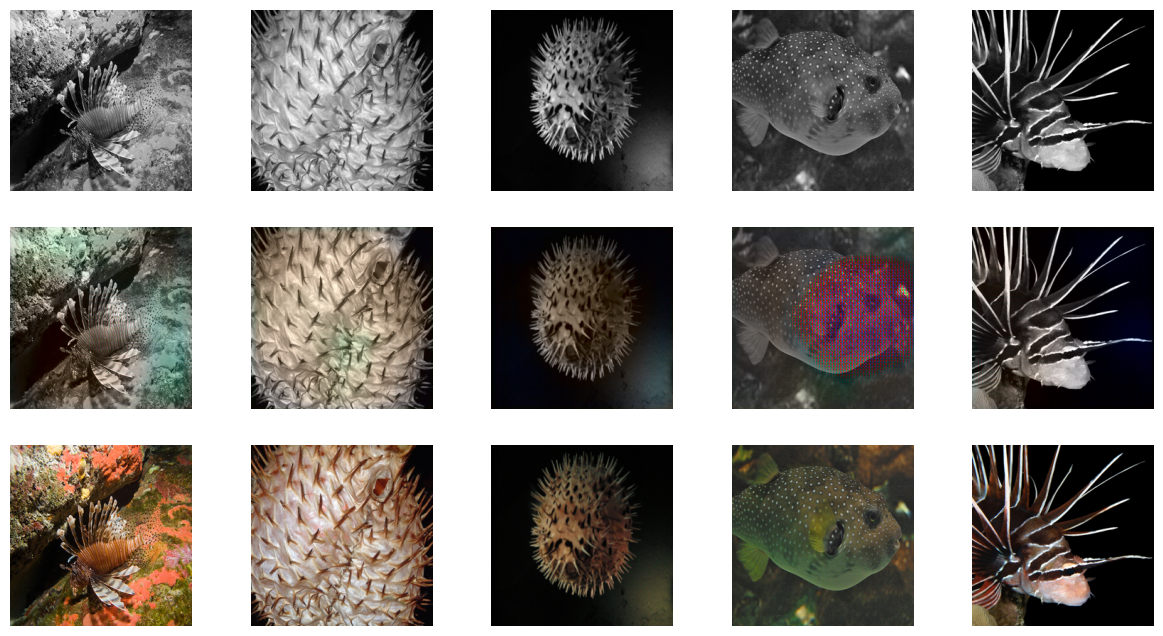

In [48]:
import time

def validate_model(model, val_loader, val_loss_meter_dict):
    with torch.no_grad():
        model.eval()
        for val_data in val_loader:
            model.setup_input(val_data)
            model.forward()
            model.validate()
            update_losses(model, val_loss_meter_dict, count=val_data['L'].size(0))
        model.train()

# TODO: Should we also save the model every epoch or so, just to eliminate the risk of losing progress?
# Just concatenate a "_<epoch index>" to the end, or create a new folder, etc.
# Or just time.time() as in 'visualize' above, to avoid risking overwrites
def train_model(model, train_dl, epochs, display_every=200, validate_every=None):
    data = next(iter(val_dataloader)) # getting a batch for visualizing the model output after fixed intrvals
    test_loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
    val_loss_meter_dict = create_loss_meters()
    for e in range(epochs):
        i = 0                                  # log the losses of the complete network
        clear_losses(test_loss_meter_dict)
        clear_losses(val_loss_meter_dict)
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, test_loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
                
            i += 1
            
            if (validate_every is not None) and (i % validate_every == 0):
                validate_model(model, val_dataloader, val_loss_meter_dict)
            
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                print("Test losses:")
                log_results(test_loss_meter_dict) # function to print out the losses
                if validate_every is not None:
                    print("Validation losses:")
                    log_results(val_loss_meter_dict) # function to print out the losses
                    
                if model.head!="classifier":
                    visualize(model, data, save=False) # function displaying the model's outputs


        torch.save(model.state_dict(), f"./model_autosave_{time.time()}.pt")
        torch.save(test_loss_meter_dict, f"./model_stats_autosave_{time.time()}.ckpt")
        torch.save(val_loss_meter_dict, f"./model_val_stats_autosave_{time.time()}.ckpt")
                
    return model, test_loss_meter_dict, val_loss_meter_dict

#model = MainModel(net_G=MLTModel(head="multitask"))
#model, test_loss_meter_dict, val_loss_meter_dict = train_model(model, train_dataloader, 30, display_every=300, validate_every=None)

# # Saving
# torch.save(model.state_dict(), "res18-unet.pt")
# torch.save(loss_meter_dict, "./loss_meter_dict.ckpt")

NUM_EPOCHS = 30
#NUM_EPOCHS = 2
#VALIDATE_EVERY = None
VALIDATE_EVERY = len(train_dataloader)/2  # Validate twice per epoch

# NOTE: Choose what to train here
#to_train = 'st_cls'
#to_train = 'st_col'
to_train = 'mt'

# NOTE: Validation is slow... validate_every=1 turns a 30-second epoch into something like 15 minutes.
# So maybe set it to 'len(train_dataloader)'?
if to_train == 'st_cls':
    st_cls_model = MainModel(net_G=MLTModel(head="classifier"))
    st_cls_model, st_cls_stats, st_cls_val_stats = train_model(st_cls_model, train_dataloader, epochs=NUM_EPOCHS, display_every=300, validate_every=VALIDATE_EVERY)
    print(st_cls_stats)
    torch.save(st_cls_model.state_dict(), "./st_cls_model.pt")
    torch.save(st_cls_stats, "./st_cls_stats.ckpt")
    torch.save(st_cls_val_stats, "./st_cls_val_stats.ckpt")

if to_train == 'st_col':
    st_col_model = MainModel(net_G=MLTModel(head="colorization"))
    st_col_model, st_col_stats, st_col_val_stats = train_model(st_col_model, train_dataloader, epochs=NUM_EPOCHS, display_every=300, validate_every=VALIDATE_EVERY)
    torch.save(st_col_model.state_dict(), "./st_col_model.pt")
    torch.save(st_col_stats, "./st_col_stats.ckpt")
    torch.save(st_col_val_stats, "./st_col_val_stats.ckpt")

if to_train == 'mt':
    mt_model = MainModel(net_G=MLTModel(head="multitask"))
    mt_model, mt_stats, mt_val_stats = train_model(mt_model, train_dataloader, epochs=NUM_EPOCHS, display_every=300, validate_every=VALIDATE_EVERY)
    torch.save(mt_model.state_dict(), "./mt_model.pt")
    torch.save(mt_stats, "./mt_stats.ckpt")
    torch.save(mt_val_stats, "./mt_val_stats.ckpt")

# TODO: Inspect to see if this includes optimizer. It does not. Should probably save this too if we want to continue training from a checkpoint
#print(st_cls_model.state_dict())

Every epoch takes about 3 to 4 minutes on Colab. After about 20 epochs you should see some reasonable results.

In [18]:
print(st_cls_stats['class_accuracy'].history_losses)

NameError: name 'st_cls_stats' is not defined

### Plot results

In [49]:
import warnings

# Without this, annot=True will only annotate the first row...
!pip install seaborn --upgrade

def plot_stat(stats, title, x_label, y_label):
    sns.set_theme(style='darkgrid', palette='deep')
    warnings.filterwarnings("ignore", category=FutureWarning)
    for name, values in stats.items():
        sns.lineplot(values, label=name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.show()
    warnings.filterwarnings("default", category=FutureWarning)

def plot_cm(cms, class_names):
    sns.set_theme(style='white', palette='deep')
    fig, axes = plt.subplots(1, len(cms), figsize=(7*len(cms), 5), sharey=True)
    for i, (title, cm) in enumerate(cms.items()):
        sns.heatmap(cm, annot=True, ax=axes[i])
        axes[i].set_xticks(range(len(class_names)))
        axes[i].set_xticklabels(class_names, rotation=45)
        axes[i].set_yticks(range(len(class_names)))
        axes[i].set_yticklabels(class_names, rotation=0, ha='right')
        axes[i].set_xlabel('Predicted label', fontsize=12)
        if i == 0:
            axes[i].set_ylabel('True label', fontsize=12)
        axes[i].set_title(title, fontsize=16)
    plt.show()

In [50]:
st_cls_stats_train = torch.load("./st_cls_stats.ckpt")
st_cls_stats_val   = torch.load("./st_cls_val_stats.ckpt")

st_col_stats_train = torch.load("./st_col_stats.ckpt")
#st_col_stats_val   = torch.load("./st_col_val_stats.ckpt")

mt_stats_train     = torch.load("./mt_stats.ckpt")
mt_stats_val       = torch.load("./mt_val_stats.ckpt")

# TODO: Seems the validation counterpart doesn't have any data? Was 1 epoch too little?
# Oh, it was run with 'validate_every=None'... What's a good value? 1?
print("(Loaded) [MT] Class train accuracies:", mt_stats_train['class_accuracy'].history_losses)
print("(Loaded) [MT] Class val accuracies:",   mt_stats_val['class_accuracy'].history_losses)

(Loaded) [MT] Class train accuracies: [0.25, 0.1875, 0.4375, 0.375, 0.125, 0.375, 0.375, 0.5, 0.5, 0.625, 0.1875, 0.6875, 0.5, 0.6875, 0.8125, 0.75, 0.6875, 0.9375, 0.6875, 0.8125, 0.6875, 0.9375, 0.8125, 0.75, 0.5625, 0.8125, 0.9375, 0.8125, 0.8125, 0.8125, 0.6875, 0.5625, 0.8125, 0.6875, 0.5625, 0.375, 0.625, 0.5, 0.9375, 0.875, 0.8125, 0.6875, 0.5, 0.9375, 0.625, 0.375, 0.75, 0.75, 1.0, 0.8125, 0.5, 0.6875, 0.4375, 0.625, 0.75, 0.5625, 0.8125, 0.75, 0.75, 0.875, 0.875, 0.6875, 0.75, 0.75, 0.9375, 0.9375, 1.0, 0.8125, 0.6875, 0.875, 0.9375, 0.9375, 0.75, 0.875, 0.8125, 0.875, 0.9375, 0.875, 0.8125, 0.8125, 0.75, 0.875, 0.9375, 0.75, 0.6875, 0.875, 0.6875, 0.875, 0.8125, 0.8125, 0.6875, 0.9375, 1.0, 0.8125, 0.9375, 0.875, 0.6875, 0.75, 0.875, 0.8125, 0.9375, 1.0, 0.8125, 0.9375, 0.875, 0.9375, 0.625, 0.9375, 0.75, 0.8125, 0.875, 0.625, 0.625, 0.9375, 0.8125, 0.9375, 0.75, 0.75, 0.75, 0.875, 0.9375, 0.9375, 0.875, 0.9375, 0.6875, 1.0, 0.9375, 0.875, 0.9375, 0.8125, 0.875, 0.875, 0.9375

#### Multi-task loss

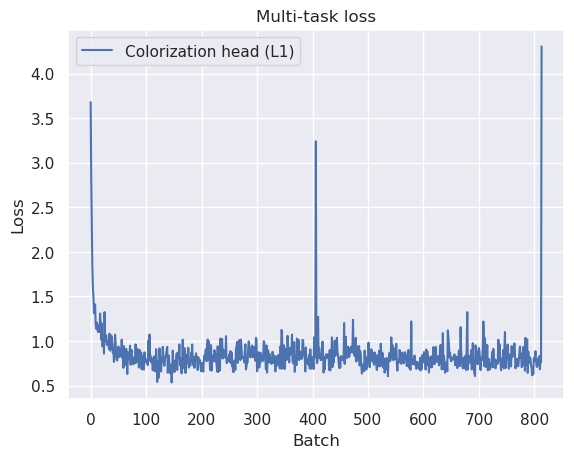

In [51]:
# NOTE: We should probably (add and) tune the classification loss's weight such that they are comparable, right?
classification_losses    = mt_stats_train['class_loss'].history_losses
colorization_losses      = [gan_loss + l1_loss for gan_loss, l1_loss in zip(mt_stats_train['loss_G_GAN'].history_losses, mt_stats_train['loss_G_L1'].history_losses)]
colorization_l1_losses   = mt_stats_train['loss_G_L1'].history_losses
colorization_gan_losses  = mt_stats_train['loss_G_GAN'].history_losses
plot_stat({
    #'Classification head (CE)': classification_losses,
           #'Colorization head (L1 + GAN)': colorization_losses,
           'Colorization head (L1)': colorization_l1_losses,
           #'Colorization head (GAN)': colorization_gan_losses
           },
           "Multi-task loss", "Batch", "Loss")

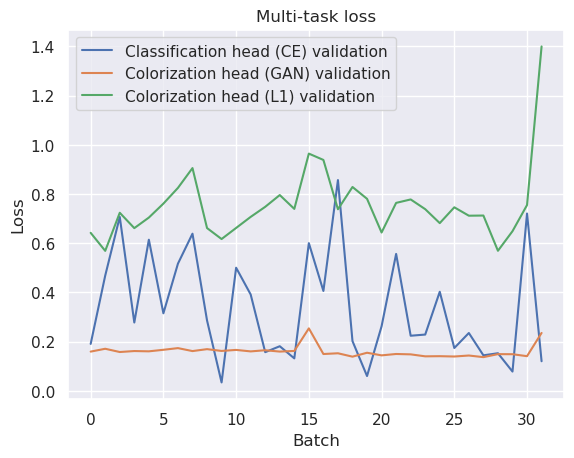

In [59]:
#print(mt_stats_val['class_loss'].history_losses)
plot_stat({
           'Classification head (CE) validation': mt_stats_val['class_loss'].history_losses,
           'Colorization head (GAN) validation': mt_stats_val['loss_G_GAN'].history_losses,
           'Colorization head (L1) validation': mt_stats_val['loss_G_L1'].history_losses
           },
           "Multi-task loss", "Batch", "Loss")

#### Multi- vs single-task classification accuracy

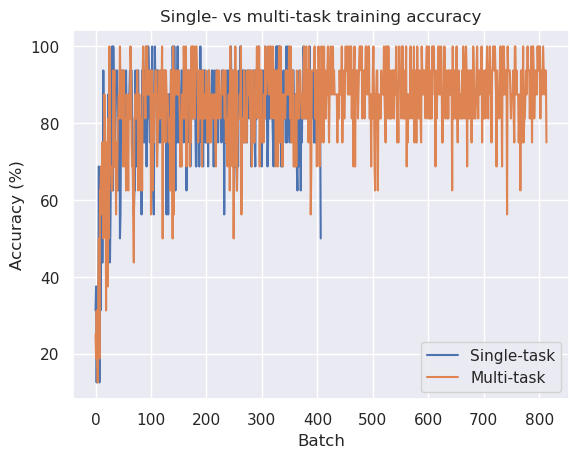

In [43]:
st_cls_accuracies = [100 * acc for acc in st_cls_stats_train['class_accuracy'].history_losses]
mt_cls_accuracies = [100 * acc for acc in mt_stats_train['class_accuracy'].history_losses]
plot_stat({'Single-task': st_cls_accuracies,
           'Multi-task': mt_cls_accuracies},
           "Single- vs multi-task training accuracy", "Batch", "Accuracy (%)")

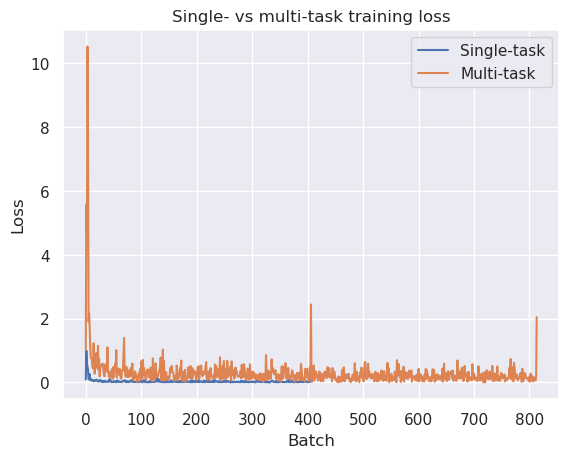

In [47]:
st_cls_losses = [loss for loss in st_cls_stats_train['class_loss'].history_losses]
mt_cls_losses = [loss for loss in mt_stats_train['class_loss'].history_losses]
plot_stat({'Single-task': st_cls_losses,
           'Multi-task': mt_cls_losses},
           "Single- vs multi-task training loss", "Batch", "Loss")

#### Multi- vs single-task colorization loss

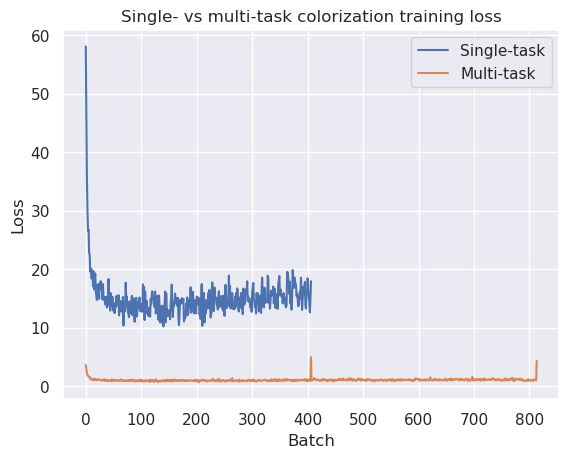

In [44]:
# NOTE: Could be interesting to compare L1 and GAN losses separately too...
st_col_losses = [gan_loss + l1_loss for gan_loss, l1_loss in zip(st_col_stats_train['loss_G_GAN'].history_losses, st_col_stats_train['loss_G_L1'].history_losses)]
mt_col_losses = [gan_loss + l1_loss for gan_loss, l1_loss in zip(mt_stats_train['loss_G_GAN'].history_losses, mt_stats_train['loss_G_L1'].history_losses)]
plot_stat({'Single-task': st_col_losses,
           'Multi-task': mt_col_losses},
           "Single- vs multi-task colorization training loss", "Batch", "Loss")

#### Classification confusion matrices

model initialized with norm initialization
model initialized with norm initialization


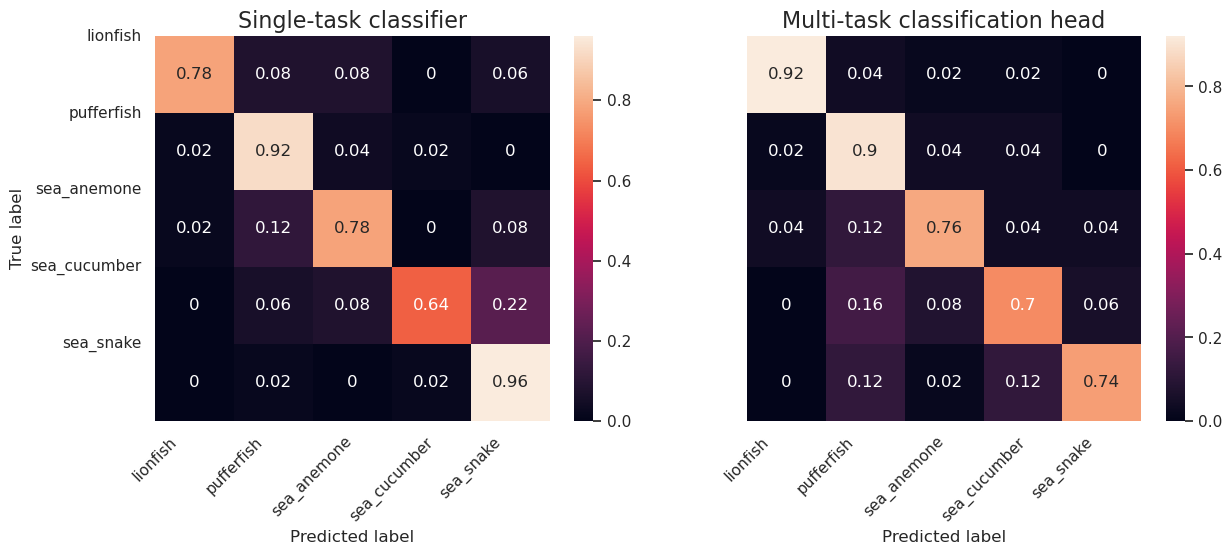

In [ ]:
from sklearn.metrics import confusion_matrix

# TODO: Train models first (the current ones were only trained for 1 or 2 epochs)
st_cls_gen = MLTModel(head='classifier')
mt_gen     = MLTModel(head='multitask')
st_cls_model = MainModel(net_G=st_cls_gen)
mt_model     = MainModel(net_G=mt_gen)

st_cls_model.load_state_dict(torch.load("st_cls_model.pt"))
mt_model.load_state_dict(torch.load("mt_model.pt"))

# Compute predictions
st_cls_preds = []
mt_preds     = []
labels       = []
with torch.no_grad():
    for batch in val_dataloader:
        st_cls_model.setup_input(batch)
        mt_model.setup_input(batch)

        st_cls_model.forward()
        mt_model.forward()

        st_cls_preds += st_cls_model.class_pred.argmax(dim=1)
        mt_preds     += mt_model.class_pred.argmax(dim=1)

        labels += batch['class']

st_cls_preds = [int(pred) for pred in st_cls_preds]
mt_preds     = [int(pred) for pred in mt_preds]
labels       = [int(label) for label in labels]
#print(st_cls_preds)
#print(mt_preds)
#print(labels)

# Compute the confusion matrix
st_cls_cm = confusion_matrix(labels, st_cls_preds)
st_cls_cm = st_cls_cm.astype('float64')

mt_cm = confusion_matrix(labels, mt_preds)
mt_cm = mt_cm.astype('float64')

# Normalize each row
for i in range(mt_cm.shape[0]):
    st_cls_cm[i, :] = st_cls_cm[i, :] / sum(st_cls_cm[i, :])
    mt_cm[i, :]     = mt_cm[i, :]     / sum(mt_cm[i, :])

#class_names = ['lionfish', 'pufferfish', 'sea-anemone', 'sea-cucumber', 'sea-snake']
plot_cm({"Single-task classifier": st_cls_cm,
         "Multi-task classification head": mt_cm}, class_names)